# Propagation Time Point Scatterer Experiments

In [1]:
import sys
sys.path.append('/homes/sep/rahul/devito/examples/')
sys.path.append('/sep/rahul/Research/Devito_Expts/Propagation_Time_Extension/')

# Import the linearized Born modeling operators

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

import DevitoOperators
from DevitoUtils import create_model, plot_image, plot_image_tx, plot_shotrecord
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_velocity, plot_perturbation, demo_model, AcquisitionGeometry

## Single shot inversion


Plot of source and receivers


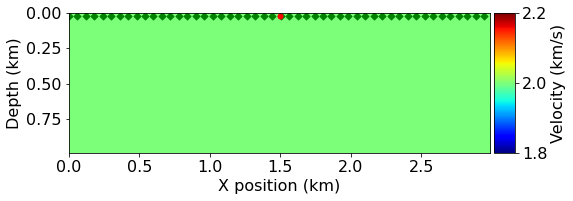

In [3]:
# Create params dicts
params = {
    "Nx": 300,
    "Nz": 100,
    "Nt": 100,   # this has to be updated later
    "nbl": 75,
    "Ns": 1,
    "Nr": 200,
    "so": 4,
    "to": 2
}

vel = create_model(shape=(params["Nx"], params["Nz"]))
vel.vp.data[:, :] = 2.0

# Simulation time, wavelet
t0 = 0.
tn = 2000.          # Simulation last 2 second (2000 ms)
f0 = 0.010          # Source peak frequency is 10Hz (0.010 kHz)

# Reflection acquisition geometry (sources and receivers are equally spaced in X direction)
src_depth = 20.0                        # Depth is 20m
rec_depth = 20.0                        # Depth is 20m

src_coord = np.empty((params["Ns"], 2))
src_coord[:, 0] = 0.5 * vel.domain_size[0]
src_coord[:, 1] = src_depth

rec_coord = np.empty((params["Nr"], 2))
rec_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Nr"])
rec_coord[:, 1] = rec_depth

# Create the geometry objects for background velocity models
src_dummy = np.empty((1, 2))

src_dummy[0, :] = src_coord[int(src_coord.shape[0] / 2), :]
geometry = AcquisitionGeometry(vel, rec_coord, src_dummy, t0, tn, f0=f0, src_type='Ricker')
params["Nt"] = geometry.nt
del src_dummy

# Define a solver object
solver = AcousticWaveSolver(vel, geometry, space_order=params["so"])

# Plot the source and receivers
print("\nPlot of source and receivers")
plot_velocity(vel, source=src_coord, receiver=rec_coord[::4, :]) # Skip every 4th receiver

# Create point perturbation
dm = np.zeros((params["Nt"], params["Nx"], params["Nz"]), dtype=np.float32)
dm[:, int(params["Nx"] / 2), int(params["Nz"] / 2)] = 1.0

In [4]:
filestr = "point_scatterer_single_shot"
dm_invert = np.load("Data/" + filestr + ".npz")["arr_0"]


Plot of inverted stack image


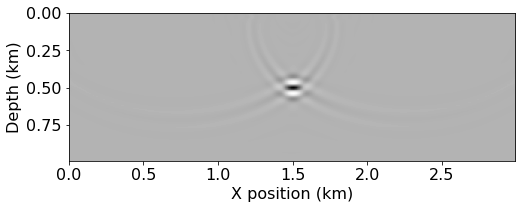


Plot of inverted result at Z = 0.5 km


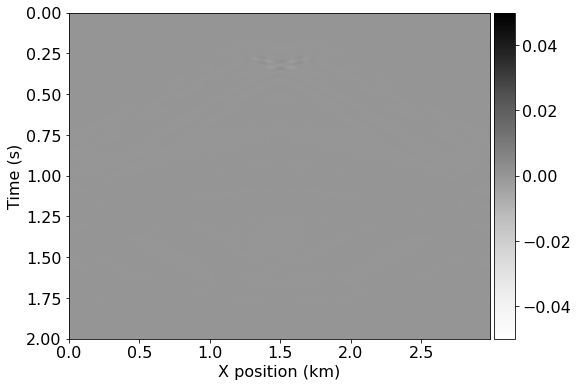

In [7]:
dm_invert_stack = np.sum(dm_invert, axis=0)

# Plot model perturbation stack
temp_model = create_model(shape=(params["Nx"], params["Nz"]))
temp_model.vp.data[:, :] *= 0
temp_model.vp.data[params["nbl"]: params["Nx"] + params["nbl"], 
           params["nbl"]: params["Nz"] + params["nbl"]] = dm_invert_stack
print("\nPlot of inverted stack image")
plot_image(temp_model, colorbar=False, colormap="Greys")
del temp_model

print("\nPlot of inverted result at Z = 0.5 km")
plot_image_tx(dm_invert[:, :, 40], x0=vel.origin[0], xn=vel.origin[0]+vel.domain_size[0], 
              t0=t0, tn=tn, scale=0.05, clip=1.0)

Compare residuals (true vs using inverted model).

In [ ]:
td_born_data_true = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)
td_born_data_inverted_model = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)

DevitoOperators.td_born_forward(
    model_pert=dm, 
    born_data=td_born_data_true, 
    src_coords=src_coord, 
    vel=vel, 
    geometry=geometry, 
    solver=solver, 
    params=params
)

DevitoOperators.td_born_forward(
    model_pert=dm_invert, 
    born_data=td_born_data_inverted_model, 
    src_coords=src_coord, 
    vel=vel, 
    geometry=geometry, 
    solver=solver, 
    params=params
)

In [ ]:
print("True residual")
plot_shotrecord(td_born_data_true[0, :, :], vel, t0, tn, clip=1.5)

print("Residual using inverted model")
plot_shotrecord(td_born_data_inverted_model[0, :, :], vel, t0, tn, clip=1.5)

## Multi shot inversion


Plot of source and receivers


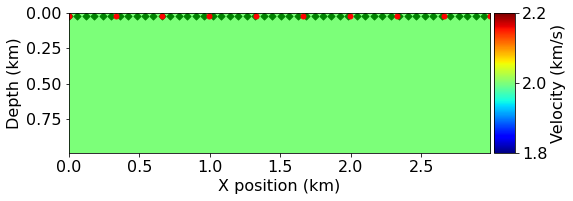

In [8]:
# Create params dicts
params = {
    "Nx": 300,
    "Nz": 100,
    "Nt": 100,   # this has to be updated later
    "nbl": 75,
    "Ns": 10,
    "Nr": 200,
    "so": 4,
    "to": 2
}

vel = create_model(shape=(params["Nx"], params["Nz"]))
vel.vp.data[:, :] = 2.0

# Simulation time, wavelet
t0 = 0.
tn = 2000.          # Simulation last 2 second (2000 ms)
f0 = 0.010          # Source peak frequency is 10Hz (0.010 kHz)

# Reflection acquisition geometry (sources and receivers are equally spaced in X direction)
src_depth = 20.0                        # Depth is 20m
rec_depth = 20.0                        # Depth is 20m

src_coord = np.empty((params["Ns"], 2))
src_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Ns"])
src_coord[:, 1] = src_depth

rec_coord = np.empty((params["Nr"], 2))
rec_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Nr"])
rec_coord[:, 1] = rec_depth

# Create the geometry objects for background velocity models
src_dummy = np.empty((1, 2))

src_dummy[0, :] = src_coord[int(src_coord.shape[0] / 2), :]
geometry = AcquisitionGeometry(vel, rec_coord, src_dummy, t0, tn, f0=f0, src_type='Ricker')
params["Nt"] = geometry.nt
del src_dummy

# Define a solver object
solver = AcousticWaveSolver(vel, geometry, space_order=params["so"])

# Plot the source and receivers
print("\nPlot of source and receivers")
plot_velocity(vel, source=src_coord, receiver=rec_coord[::4, :]) # Skip every 4th receiver

# Create point perturbation
dm = np.zeros((params["Nt"], params["Nx"], params["Nz"]), dtype=np.float32)
dm[:, int(params["Nx"] / 2), int(params["Nz"] / 2)] = 1.0

In [9]:
filestr = "point_scatterer_multi_shot"
dm_invert = np.load("Data/" + filestr + ".npz")["arr_0"]


Plot of inverted stack image


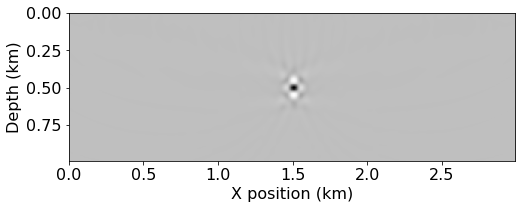


Plot of inverted result at Z = 0.5 km


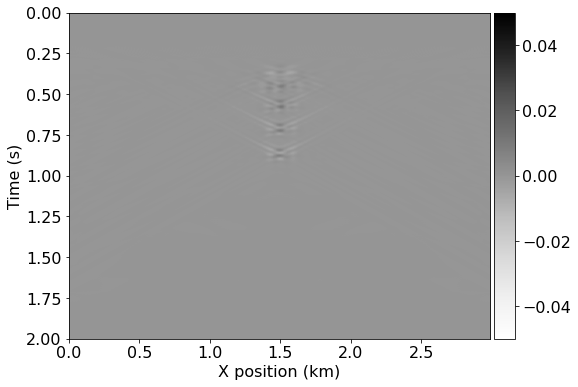

In [10]:
dm_invert_stack = np.sum(dm_invert, axis=0)

# Plot model perturbation stack
temp_model = create_model(shape=(params["Nx"], params["Nz"]))
temp_model.vp.data[:, :] *= 0
temp_model.vp.data[params["nbl"]: params["Nx"] + params["nbl"], 
           params["nbl"]: params["Nz"] + params["nbl"]] = dm_invert_stack
print("\nPlot of inverted stack image")
plot_image(temp_model, colorbar=False, colormap="Greys")
del temp_model

print("\nPlot of inverted result at Z = 0.5 km")
plot_image_tx(dm_invert[:, :, 60], x0=vel.origin[0], xn=vel.origin[0]+vel.domain_size[0], 
              t0=t0, tn=tn, scale=0.05, clip=1.0)

Compare residuals (true vs using inverted model).

In [11]:
td_born_data_true = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)
td_born_data_inverted_model = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)

DevitoOperators.td_born_forward(
    model_pert=dm, 
    born_data=td_born_data_true, 
    src_coords=src_coord, 
    vel=vel, 
    geometry=geometry, 
    solver=solver, 
    params=params
)

DevitoOperators.td_born_forward(
    model_pert=dm_invert, 
    born_data=td_born_data_inverted_model, 
    src_coords=src_coord, 
    vel=vel, 
    geometry=geometry, 
    solver=solver, 
    params=params
)

True residual (3rd shot)


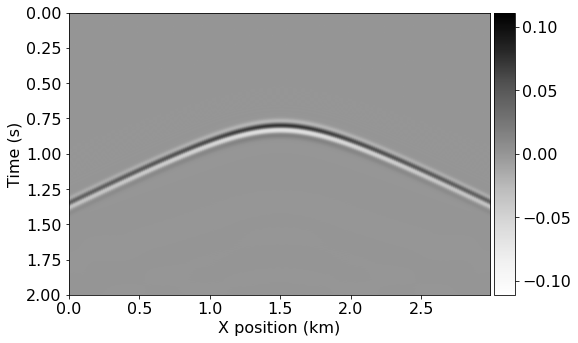

Residual using inverted model (3rd shot)


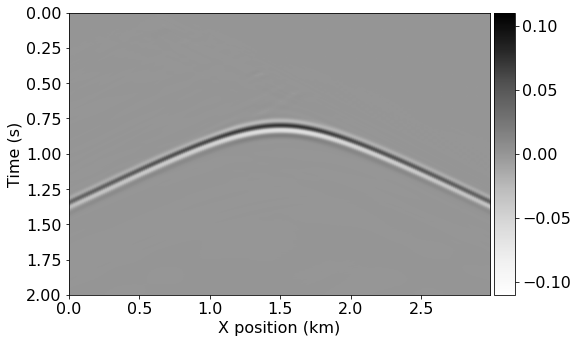

True residual (6th shot)


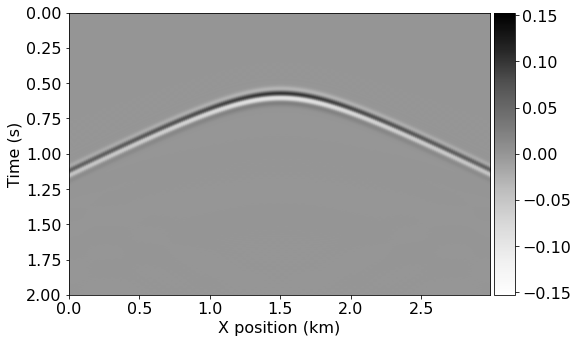

Residual using inverted model (6th shot)


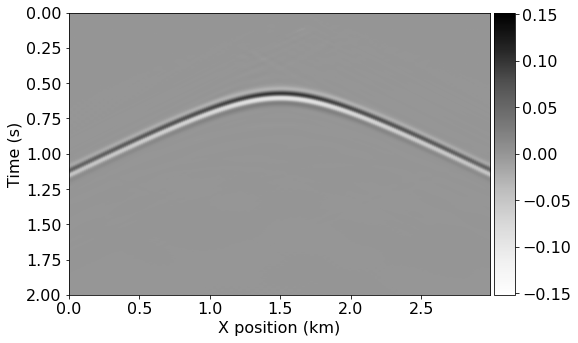

In [12]:
print("True residual (3rd shot)")
plot_shotrecord(td_born_data_true[2, :, :], vel, t0, tn, clip=1.5)

print("Residual using inverted model (3rd shot)")
plot_shotrecord(td_born_data_inverted_model[2, :, :], vel, t0, tn, clip=1.5)

print("True residual (6th shot)")
plot_shotrecord(td_born_data_true[5, :, :], vel, t0, tn, clip=1.5)

print("Residual using inverted model (6th shot)")
plot_shotrecord(td_born_data_inverted_model[5, :, :], vel, t0, tn, clip=1.5)